In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_addons
!pip install stockstats

     |████████████████████████████████| 706kB 11.0MB/s 


In [5]:
import numpy as np 
from numpy import newaxis
import pandas as pd 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.models import Sequential
from keras import optimizers
from keras.utils import normalize
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates 
import tensorflow as tf
import tensorflow_addons as tfa
from keras import backend as K
from stockstats import StockDataFrame



In [6]:
def dejarPredictores(data, predictores, valor): #metodo para dejar los predictores y el valor a predecir solamente
  print("sacando predictores")
  return data[predictores + [valor]] 
def dibujarGraficaTemporal(data , valor): #metodo para plotear
  data[valor].plot() 
def dividirTestTrain(data, porcentaje = 0.9): #metodo para splitear entre test y train
    row = round(porcentaje * data.shape[0])
    train = data[:row]
    test = data[row:]
    return train,test
def cargarDatos(ruta, valor, fecha, len_x, len_y, variablesAPredecir, predictores, division = 0.9): #metodo para cargar los datos
  data = pd.read_csv(ruta,index_col=fecha, parse_dates=[fecha]) #leemos los datos con la fecha
  print(data.head())
  print("dataset cargado")
  print(type(data[valor]))
  data2 = dejarPredictores(data, predictores, valor) #dejamos los predictores
  print(data2.head())
  dibujarGraficaTemporal(data,valor) #dibujamos la grafica
  print(data2.shape[0])
  y = dejarPredictores(data, variablesAPredecir, valor) #separamos entre x e y 
  print(y.head())
  x = dejarPredictores(data, predictores, valor)
  print(x.head())
  data3x = []
  data3y = []
  for i in range(data2.shape[0] - (len_x + len_y)): #hacemos la normalizacion por slot y añadimos los slots a sus respectivas listas
    data3x.append(x[i : i + len_x])
    data3x[i] = (data3x[i] - data3x[i].mean()) / (data3x[i].max() - data3x[i].min())
    data3y.append(y[i :  i + len_x + len_y])
    data3y[i] = (data3y[i] - data3y[i].mean()) / (data3y[i].max() - data3y[i].min())
    data3y[i] = data3y[i][len_x : len_x + len_y]
  data3x = np.array(data3x)
  data3y = np.array(data3y)
  print("x shape",data3x.shape)
  print("y shape",data3y.shape)
  row = round(division * data3x.shape[0])
  x_train = data3x[:row,] #separamos entre train y test
  y_train = data3y[:row,]
  y_train = y_train.squeeze()
  x_test = data3x[row:,]
  y_test = data3y[row:,]
  y_test = y_test.squeeze()
  print("x train shape",x_train.shape)
  print("y train shape",y_train.shape)
  print("x test shape",x_test.shape)
  print("y test shape",y_test.shape)
  return data, x_train , y_train , x_test, y_test

                 high    low       open  ...      trix    change          vr
Date                                     ...                                
2006-11-13  17.870001  17.76  17.830000  ...  0.277565 -0.056276  187.897659
2006-11-14  17.940001  17.75  17.900000  ...  0.289115  0.900900  206.172072
2006-11-15  17.910000  17.77  17.790001  ...  0.297471 -0.390623  174.617213
2006-11-16  17.879999  17.75  17.840000  ...  0.301774 -0.112047  172.067723
2006-11-17  17.920000  17.65  17.680000  ...  0.303932  0.448682  167.616251

[5 rows x 74 columns]
dataset cargado
<class 'pandas.core.series.Series'>
sacando predictores
                 open       high    low    volume       kdjk  close
Date                                                               
2006-11-13  17.830000  17.870001  17.76  251100.0  83.004379  17.76
2006-11-14  17.900000  17.940001  17.75  902100.0  88.046519  17.92
2006-11-15  17.790001  17.910000  17.77  442600.0  89.173868  17.85
2006-11-16  17.840000  17.

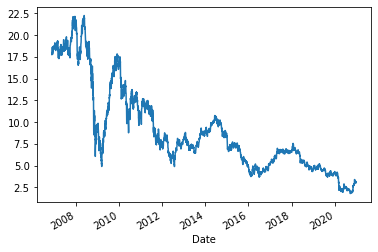

In [7]:
ruta = '/content/drive/MyDrive/proyectos data/FullData.csv'
# tmp

"""
data = 0
open = 1
high = 2
low = 4
close = 5
adjClose = 6
colume = 7
"""
variables_a_predecir = ['open','high','low','volume']
variables_extra_df = ['kdjk']
predictores = variables_a_predecir + variables_extra_df

principal_target = 'close'
fecha = 'Date'
len_x = 100
len_y = 1

data, x_train , y_train , x_test, y_test = cargarDatos(ruta, principal_target, fecha, len_x, len_y, variables_a_predecir,predictores) #ejecutamos el metodo cargar datos
#x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],x_train.shape[2], 1))
#x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],x_test.shape[2], 1))

In [9]:
#creamos la red neuronal
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))
model = Sequential() #https://keras.io/guides/sequential_model/
model.add(LSTM(100, input_shape=(None,x_train.shape[2]), dropout=0.2, recurrent_dropout=0.2))
#model.add(Dropout(0.2))
model.add(Dense(len(variables_a_predecir) + 1 , activation = "linear")) #https://keras.io/api/layers/core_layers/dense/
model.compile(loss='mse', optimizer='adam',metrics=[tf.keras.metrics.MeanSquaredError(),r_square,r_square_loss])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42800     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 43,305
Trainable params: 43,305
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
print(x_train.shape) 
print(y_train.shape)

(3111, 100, 6)
(3111, 5)


In [11]:
model.fit(x_train, y_train, batch_size=50, epochs=10, validation_data = (x_test, y_test))

Epoch 1/10
63/63 [==============================] - 13s 163ms/step - loss: 0.0394 - mean_squared_error: 0.0394 - r_square: 0.6128 - r_square_loss: 0.3872 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_r_square: 0.6401 - val_r_square_loss: 0.3599
Epoch 2/10
63/63 [==============================] - 10s 155ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - r_square: 0.8528 - r_square_loss: 0.1472 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_r_square: 0.6835 - val_r_square_loss: 0.3165
Epoch 3/10
63/63 [==============================] - 10s 154ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - r_square: 0.8670 - r_square_loss: 0.1330 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_r_square: 0.7076 - val_r_square_loss: 0.2924
Epoch 4/10
63/63 [==============================] - 10s 155ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - r_square: 0.8700 - r_square_loss: 0.1300 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_r_square: 0.7163 

(346, 5)
(346, 5)
(346, 1)
(346, 1)


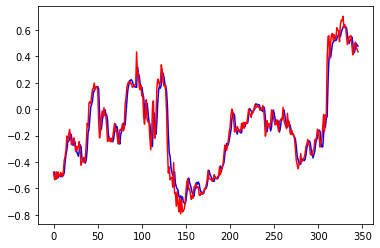

In [12]:
#probamos la predicción

y = model.predict(x_test)
print(y.shape)
print(y_test.shape)
print(y[:,-1:].shape)
print(y_test[:,-1:].shape)
plt.close() 
plt.plot(y[:,-1:],color = "blue")
plt.plot(y_test[:,-1:],color = "red")



In [29]:
def dejar_columnas(data, columnas):
  return data[columnas]
#para que este metodo las ultimas columnas que prediga la red neuronal tienen que ser las que no se pueden calcular
#y en el oren dado
variables_importantes = ['open','high','low','volume']
def convertir_np_a_dataframe(np_arr, variables):
  #sel_arr = np.delete(np_arr, np.s_[:np_arr.shape[1]-len(variables)],1)
  df = pd.DataFrame(np_arr, columns=variables)
  return df


  


In [67]:
'''
creamos un metdodo para predecir es es que se usara finalmente 
-este metodo te permite especificar el numero de predictores (dias) y el numero de predicciones (dias) 
-te permite establecer las variables importantes (las que va a predecir la rede neuronal)
-tiene un flag, (0) realiza el calculo de variables segundarias con los dias especificados en num_predictores
(1) realiza el calculo de variables segundarias con los dias especificados en tam_calculo
-el calculo de variables segundarias esta en otro notebook hay que implementarlo en el metodo.
'''
target = ['close']
def generarPredicciones(data, num_predictores, num_predicciones, variables_importantes, flag = 0, tam_calculo = 100):
  data = dejar_columnas(data, variables_importantes+variables_extra_df+target)
  data = (data - data.mean()) / (data.max() - data.min())
  x = data
  y = []
  x = np.array(x)
 
  dataNP = np.array(data)
  dataF_data = data.copy()
  dataF_data = dejar_columnas(dataF_data, variables_importantes +variables_extra_df+  target)
  for a in range(len(data) - 1):
    y.append(None)
  for i in range(num_predicciones):
    topredict = np.expand_dims(x, axis = 0) #preparo x para predecir
    np_predicho = model.predict(topredict) #predigo
    y.append(np_predicho[:,-1:])
    x = x[1:, :] #elimino el primer valor
    dataF_predicho = convertir_np_a_dataframe(np_predicho, variables_importantes + target) #convertir a datafrme la prediccion
    dataF_X = convertir_np_a_dataframe(x, variables_importantes + variables_extra_df + target) #convertir x a dataframe
    dataF_X = dejar_columnas(dataF_X, variables_importantes + target)#elimino las columnas extras para concatenar
    dataF_X = pd.concat([dataF_X,dataF_predicho]) #concateno x con la prediccion
    #creacion de variables
    tempStock = StockDataFrame.retype(dataF_X)#convierto la concatenacion a un dataframe especial
    for var_df in variables_extra_df:#genero las variables nuevas con la x ya concatenada
      tempStock.get(var_df)
    tempStock[variables_extra_df] = (tempStock[variables_extra_df] - tempStock[variables_extra_df].mean()) / (tempStock[variables_extra_df].max() - tempStock[variables_extra_df].min())
    tempStock = dejar_columnas(tempStock, variables_importantes + variables_extra_df + target)#dejo las columnas que me interesan
    x = np.array(tempStock)
    print(x) #convierto x a nparray
    if (flag == 1):
      dataNP = dataNP[-tam_calculo:][:]
      dataF_data = convertir_np_a_dataframe(dataNP, variables_importantes + variables_extra_df + target)
      dataF_data = dejar_columnas(dataF_data, variables_importantes + target)
      dataF_data = pd.concat([dataF_data,dataF_predicho])

      #creacion de variables
      tempStock = StockDataFrame.retype(dataF_data)
      for var_df in variables_extra_df:
        tempStock.get(var_df)
      tempStock[variables_extra_df] = (tempStock[variables_extra_df] - tempStock[variables_extra_df].mean()) / (tempStock[variables_extra_df].max() - tempStock[variables_extra_df].min())
      tempStock = dejar_columnas(tempStock, variables_importantes + variables_extra_df + target)

      x = np.array(tempStock)
      x = x[-num_predictores:][:]
  return y



In [68]:
#utilizamos el metodo para predecir
print(data.shape[0]-100)
print(data.iloc[:data.shape[0]-100,])
y = generarPredicciones(data.iloc[:data.shape[0]-500,], 100, 100, variables_importantes, 1, 200)



Se han truncado las últimas 5000 líneas del flujo de salida.
[[-2.67089589e-01 -2.68078716e-01 -2.64761357e-01  7.45580968e-03
  -1.33946555e-01 -2.64498760e-01]
 [-2.65467982e-01 -2.67541960e-01 -2.62039517e-01 -3.70016550e-02
  -1.84323273e-01 -2.65037856e-01]
 [-2.59522029e-01 -2.61100743e-01 -2.56595864e-01  3.99721028e-03
   1.32882832e-01 -2.59107930e-01]
 [-2.61684189e-01 -2.63784571e-01 -2.57684595e-01 -3.19240442e-04
   2.72850364e-01 -2.60186096e-01]
 [-2.62765269e-01 -2.64858107e-01 -2.60406408e-01  6.04171471e-03
   1.15901687e-01 -2.63959664e-01]
 [-2.61143636e-01 -2.63784571e-01 -2.57684595e-01 -2.94206721e-02
   1.90026396e-01 -2.61264262e-01]
 [-2.60062556e-01 -2.61100743e-01 -2.56595864e-01 -3.26852043e-02
   4.89704937e-01 -2.57490668e-01]
 [-2.56819316e-01 -2.60563962e-01 -2.56051486e-01 -1.83835620e-02
   5.03108362e-01 -2.59647000e-01]
 [-2.61684189e-01 -2.61637498e-01 -2.58228947e-01 -1.50201421e-02
   6.05581836e-01 -2.58029764e-01]
 [-2.63305796e-01 -2.67005179e

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


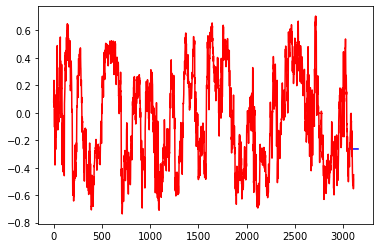

In [71]:
plt.plot(y,color = "blue")
plt.plot(np.vstack((y_train))[:,-1:], color = "red")

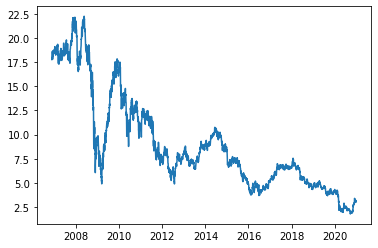

In [ ]:
plt.plot(data[principal_target])